# Improving Your Marketing Measurement with Hierarchical MMMs  
*A practical DTC example using Bayesian partial pooling in PyMC*

Marketing Mix Models (MMMs) often produce one frustrating result:

> A small, always-on channel gets an ROI estimate that is either wildly uncertain or clearly implausible.

This notebook demonstrates **why that happens**, and how **hierarchical modeling** can improve measurement by allowing weak channels to *borrow strength* from the rest of the mix.

We’ll use a simplified, educational MMM built in **PyMC**, focusing on one specific channel — **c10** — which we’ll interpret as:

**c10 = Paid Social (TOF Brand Always-on)**  
(A low-budget, awareness-focused campaign that has been running continuously, but receives limited testing, creative refresh, or strategic investment.)

In many DTC businesses, this type of channel tends to have:
- consistent spend
- limited variation week to week
- weak signal relative to larger channels
- effects that are real, but hard to isolate

That makes it a great candidate for exploring **hierarchical pooling**, where we allow the model to “borrow strength” from other channels.

---

## Business context (DTC example)

Assume we work at a DTC subscription brand (think: skincare, supplements, meal kits, etc.). Each week we spend across a set of channels (Paid Search, Paid Social, Influencers, YouTube, Email, etc.).

Some channels are large and easy to estimate because they have strong variation and signal.

But other channels — like **always-on TOF brand social ads** — often have:
- low budget
- little creative rotation
- little targeting change
- no meaningful tests
- and KPI impact that is plausible, but not obvious in the data

This creates a classic MMM failure mode:

> the model is forced to estimate a channel effect using very little usable information.

---

## The modeling problem we are demonstrating

We will fit a simplified MMM where each channel has an effect size.

The key question is: **how should we treat those channel effects?**

### Unpooled model
Each channel’s coefficient is estimated independently. For c10, this often means the posterior is driven by noise.

### Hierarchical model (partial pooling)
Channel effects come from a shared distribution. If c10’s data is weak, it shrinks toward the group mean; if c10’s data is strong, it can deviate.

---

## A quick note on uncertainty (HDI)

We’ll summarize uncertainty using the **94% HDI** (Highest Density Interval). A wide HDI is not necessarily a failure — it may be the correct answer.

But wide uncertainty becomes a practical business problem when it prevents decision-making. Hierarchical modeling doesn’t “fake confidence”; it encodes a reasonable assumption:

> channels are not totally unrelated, so small channels shouldn’t behave like isolated statistical outliers.

---

## What to watch for

We’ll compare four approaches:

1. **Unpooled model** — c10 estimated independently → typically unstable.  
2. **Centered hierarchy** — partial pooling improves location but can sample poorly when signal is weak.  
3. **Non-centered hierarchy** — same assumptions, better parameterization for weak data.  
4. **Non-centered + pooling multiplier** — a practical knob to tune how strongly c10 shrinks toward the group.

> **Key takeaway:** If a channel is small, always-on, and has limited variation, an MMM may struggle to estimate it independently. Hierarchical priors improve measurement by allowing the model to borrow strength across channels.


In [24]:
# Core
import numpy as np
import pandas as pd

# Probabilistic modeling
import pymc as pm
import arviz as az

# Prior helper (moved out of pymc-marketing)
from pymc_extras.prior import Prior

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# --- Marketing-friendly channel names (presentation only) ---
CHANNEL_NAME = {
    "c1": "Paid Search",
    "c2": "Paid Social (Retargeting)",
    "c3": "Paid Social (Prospecting - DR)",
    "c4": "YouTube",
    "c5": "Influencers / Creators",
    "c6": "Display / Programmatic",
    "c7": "Affiliates",
    "c8": "Email / CRM",
    "c9": "Organic / Direct (proxy)",
    "c10": "Paid Social (TOF Brand Always-on)",
}

WEAK_CHANNEL = "c10"
WEAK_CHANNEL_LABEL = CHANNEL_NAME[WEAK_CHANNEL]


def apply_channel_labels_to_idata(idata, channel_name_map: dict, coord_name: str = "channel"):
    """Replace idata's channel coordinate labels (e.g., c1..c10) with human-readable names."""
    if idata is None:
        return None

    def _rename_coords(ds):
        if ds is None:
            return None
        if coord_name not in ds.coords:
            return ds
        old = list(ds.coords[coord_name].values)
        new = [channel_name_map.get(str(x), str(x)) for x in old]
        return ds.assign_coords({coord_name: new})

    for grp in ["posterior", "prior", "posterior_predictive", "sample_stats", "prior_predictive"]:
        if hasattr(idata, grp):
            try:
                setattr(idata, grp, _rename_coords(getattr(idata, grp)))
            except Exception:
                pass

    return idata


In [25]:
def generate_data(
    seed: int = 42,
    start_date: str = "2023-01-01",
    mu_beta: float = 0.5,
    sigma_beta: float = 0.05,
    alpha: float = 0.5,
    sigma_y: float = 0.1,
    spend_sd_strong: float = 0.6,
    spend_sd_weak: float = 0.05,
):
    """
    Generate positive-only weekly regression data with 10 channels (c1–c10)
    from 2023-01-01 to today, where c10 is deliberately weakly identified.

    Conceptual data-generating process (log scale):
        log(y_t) = alpha + sum_j beta_j * log(c_{j,t}) + epsilon_t
        beta_j ~ Normal(mu_beta, sigma_beta)
        epsilon_t ~ Normal(0, sigma_y)

    After exponentiation:
        y_t > 0, c_{j,t} > 0

    Weak channel (c10):
      - much lower variance in spend
      - contributes little identifying information about its coefficient

    Parameters
    ----------
    seed : int
        Random seed for reproducibility.
    start_date : str
        Start date for weekly data.
    mu_beta : float
        Population mean of channel elasticities.
    sigma_beta : float
        Population standard deviation of channel elasticities.
    alpha : float
        Intercept on the log-sales scale.
    sigma_y : float
        Noise standard deviation on the log-sales scale.
    spend_sd_strong : float
        Log-scale standard deviation of spend for strong channels.
    spend_sd_weak : float
        Log-scale standard deviation of spend for the weak channel (c10).

    Returns
    -------
    df : pandas.DataFrame
        Columns: date, y, c1, ..., c10 (all strictly positive).
    truth : dict
        True data-generating parameters.
    """
    import numpy as np
    import pandas as pd

    rng = np.random.default_rng(seed)

    # Weekly date index
    dates = pd.date_range(start=start_date, end=pd.Timestamp.today(), freq="W")
    n = len(dates)

    n_channels = 10
    weak_idx = 9  # c10

    # True channel elasticities
    beta_true = rng.normal(mu_beta, sigma_beta, size=n_channels)

    # Spend variability (log scale)
    spend_sd = np.full(n_channels, spend_sd_strong)
    spend_sd[weak_idx] = spend_sd_weak

    # Generate positive spend (log-normal)
    log_spend = rng.normal(0.0, spend_sd, size=(n, n_channels))
    spend = np.exp(log_spend)

    # Generate sales (log-linear model)
    log_y = alpha + log_spend @ beta_true + rng.normal(0.0, sigma_y, size=n)
    y = np.exp(log_y)

    df = pd.DataFrame(
        spend,
        columns=[f"c{i+1}" for i in range(n_channels)],
    )
    df.insert(0, "date", dates)
    df["y"] = y

    truth = {
        "alpha": alpha,
        "mu_beta": mu_beta,
        "sigma_beta": sigma_beta,
        "beta": beta_true,
        "weak_channel": "c10",
    }

    return df, truth

df, truth = generate_data()

In [26]:
df.head(5)

,date,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,y
0,2023-01-01,1.694925,1.594683,1.040414,1.966676,1.323799,0.597157,1.247636,0.562519,1.693962,0.997507,3.860527
1,2023-01-08,0.895013,0.664608,2.082408,0.911451,0.773371,0.809547,1.376282,1.245163,1.280998,1.021775,2.516088
2,2023-01-15,3.614627,0.783606,0.735396,0.613691,1.447138,1.968720,0.933916,0.604053,0.609761,1.033065,1.973012
3,2023-01-22,1.561977,1.385267,0.670786,1.149465,1.072520,1.140211,1.686841,1.143573,1.502827,1.003385,3.370303
4,2023-01-29,1.189427,1.460491,0.417157,0.825470,0.754105,0.681590,0.847821,2.452149,0.594819,1.049605,0.986299


The following figure shows the synthetic weekly dataset used throughout this notebook.

- **Top panel:** outcome `y` (think: weekly revenue or orders)
- **Bottom panel:** channel spends `c1–c10`
- **c10 is our focus:** **Paid Social (TOF Brand Always-on)** — small, steady spend with limited variation (a classic weak-signal MMM channel)

Even with correctly specified mechanics, channels like c10 tend to be hard to identify unless they have meaningful variation or experimentation.


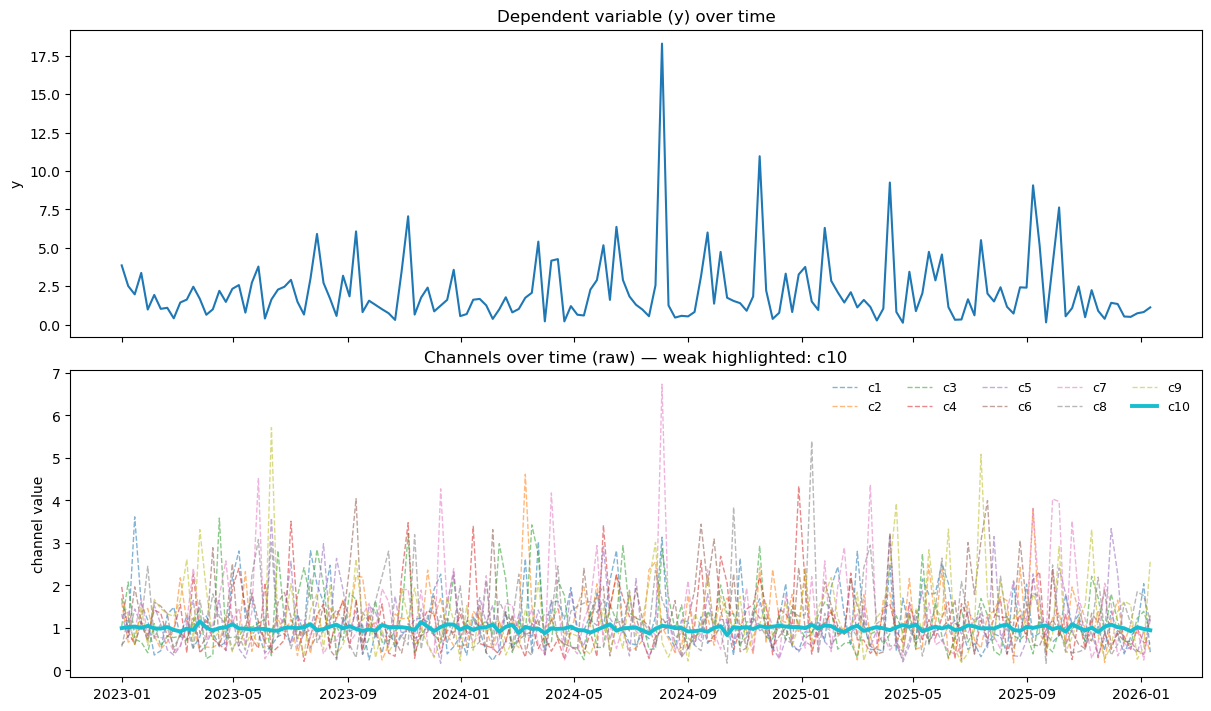

In [27]:
def plot_weekly_data(df, weak="c10", normalize_channels=True):
    """
    Plot weekly data showing y and all channels over time, with the weak channel highlighted.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns: 'date', 'y', and channel columns (e.g., c1..c10).
    weak : str
        Name of the weak channel column to highlight (default 'c10').
    normalize_channels : bool
        If True, z-score channels so they can be compared on one axis.
        If False, plot channels on their original scale.
    """
    d = df.sort_values("date").copy()
    channel_cols = [c for c in d.columns if c.startswith("c") and c[1:].isdigit()]

    # Optionally normalize channels for comparability
    if normalize_channels:
        X = d[channel_cols]
        Xn = (X - X.mean()) / X.std(ddof=0)
        d[channel_cols] = Xn

    fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True, constrained_layout=True)

    # 1) Dependent variable
    axes[0].plot(d["date"], d["y"])
    axes[0].set_title("Outcome (y) over time (e.g., weekly revenue/orders)")
    axes[0].set_ylabel("y")

    # 2) Channels
    for c in channel_cols:
        lw = 2.8 if c == weak else 1.0
        ls = "-" if c == weak else "--"
        alpha = 1.0 if c == weak else 0.55
        axes[1].plot(d["date"], d[c], linewidth=lw, linestyle=ls, alpha=alpha, label=CHANNEL_NAME.get(c, c))

    weak_label = CHANNEL_NAME.get(weak, weak)
    axes[1].set_title(f"Channels over time ({'z-scored' if normalize_channels else 'raw'}) — highlight: {weak_label}")
    axes[1].set_ylabel("channel value")
    axes[1].legend(ncol=5, fontsize=9, frameon=False)

    plt.figtext(0.01, -0.03, f"Note: {weak_label} is low-spend and low-variation (classic MMM weak-signal channel).", ha="left", fontsize=9)

    plt.show()

plot_weekly_data(df, weak="c10", normalize_channels=False)


### Data overview and motivation for hierarchical modeling

The figure shows weekly **sales (`y`)** and **channel spend (`c1`–`c10`)** from 2023 onward. All values are positive by construction.

* Sales (`y`) exhibit noisy week-to-week variation with no strong trend or seasonality, keeping the focus on coefficient estimation rather than time-series structure.
* Channels `c1`–`c9` show substantial variability over time and are likely to be well identified in a regression model.
* Channel **`c10`** (highlighted) has **much lower variance** and noticeably flatter dynamics, providing little information to estimate its effect independently.

This imbalance suggests a modeling challenge: not all channel coefficients are equally identifiable from the data. In an unpooled model, the coefficient for `c10` is expected to be weakly identified, with high uncertainty and strong prior dependence.

Hierarchical models address this by allowing channel coefficients to share information through a common population distribution. Strong channels remain data-driven, while weak channels like `c10` borrow strength from the global structure, leading to more stable and interpretable estimates.


---

---

### Reusable plotting functions

Before proceeding, we define a pair of **plotting functions** that will be reused throughout the notebook.
These functions standardize common tasks such as:

* comparing coefficients across models
* plotting posterior distributions against known ground truth

Defining them once keeps the modeling sections focused on **conceptual differences** rather than repeated plotting or diagnostics code.


In [28]:
def plot_coeff_forest_prior_posterior(
    idata,
    idata_prior,
):
    """
    Forest plot for alpha + betas with prior vs posterior overlay (ArviZ).

    Assumptions (fixed across your notebook):
    - model contains variables named: 'alpha' and 'beta'
    - beta uses the 'channel' coordinate so labels appear as beta[c1]..beta[c10]
    - you want both prior and posterior shown on the same forest plot

    Parameters
    ----------
    model : pm.Model
        The PyMC model context used to sample idata.
    idata : arviz.InferenceData
        Posterior samples from pm.sample(...).

    Returns
    -------
    axes
        Matplotlib axes returned by az.plot_forest.
    idata_with_prior : arviz.InferenceData
        The input idata extended with a `prior` group.
    """
    # Combine (adds idata.prior so ArviZ can overlay prior/posterior)
    idata_with_prior = idata.copy()
    idata_with_prior.extend(idata_prior)
    # Apply marketing-friendly channel labels for plotting
    apply_channel_labels_to_idata(idata_with_prior, CHANNEL_NAME)

    axes = az.plot_forest(
        [idata_with_prior.prior, idata_with_prior.posterior],
        model_names=["Prior", "Posterior"],
        kind="forestplot",
        var_names=["beta"],
        combined=True,
        hdi_prob=0.94,
        figsize=(12, 5),
    )
    axes[0].set_title("Coefficients: prior vs posterior")
    # Force consistent x-axis limits
    axes[0].set_xlim(-0.3, 0.7)

    return axes, idata_with_prior


In [29]:
def plot_channel_beta_posterior_vs_truth(
    idata,
    truth,
    highlight_channel: str = "c10",
    figsize=(10, 5),
):
    """
    Plot posterior distribution of beta per channel as a horizontal seaborn violin plot,
    with true beta values overlaid.

    Assumptions (fixed across models):
    - Parameter name is 'beta'
    - truth['beta'] contains true beta values
    - beta has dims ('chain', 'draw', 'channel')
    - channel labels stored in coord 'channel' (e.g. c1..c10)

    Parameters
    ----------
    idata : arviz.InferenceData
        Posterior samples.
    truth : dict
        True data-generating parameters (expects key 'beta').
    highlight_channel : str
        Channel to visually emphasize (default 'c10').
    figsize : tuple
        Matplotlib figure size.

    Returns
    -------
    fig : matplotlib.figure.Figure
    ax : matplotlib.axes.Axes
    """
    if "beta" not in idata.posterior:
        raise KeyError("'beta' not found in idata.posterior.")
    if "beta" not in truth:
        raise KeyError("'beta' not found in truth dict.")

    beta = idata.posterior["beta"]
    if "channel" not in beta.dims:
        raise ValueError("Expected 'beta' to have a 'channel' dimension.")

    channels = [str(x) for x in list(beta.coords["channel"].values)]
    channel_labels = [CHANNEL_NAME.get(ch, ch) for ch in channels]
    highlight_label = CHANNEL_NAME.get(highlight_channel, highlight_channel)

    # Extract posterior samples → (sample, channel)
    beta_samples = az.extract(idata, var_names=["beta"]).T.to_numpy()

    beta_true = np.asarray(truth["beta"]).ravel()
    if beta_true.size != len(channels):
        raise ValueError("Length of truth['beta'] does not match number of channels.")

    # Long-form dataframe for seaborn
    df_long = (
        pd.DataFrame(beta_samples, columns=channel_labels)
        .melt(var_name="channel", value_name="beta")
    )

    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)

    sns.violinplot(
        data=df_long,
        x="beta",
        y="channel",
        orient="h",
        inner="quartile",
        cut=0,
        ax=ax,
    )

    ax.axvline(0, linewidth=1)

    # Overlay true beta values
    truth_df = pd.DataFrame(
        {
            "channel": channel_labels,
            "beta": beta_true,
        }
    )

    ax.scatter(
        truth_df["beta"],
        truth_df["channel"],
        color="black",
        zorder=5,
        label="True value",
    )

    # Highlight weak channel
    if highlight_label in channel_labels:
        ax.axhline(
            y=channel_labels.index(highlight_label),
            linestyle="--",
            alpha=0.4,
        )

    ax.set(
        title="Posterior channel effects (beta) by channel (94% HDI implied by quartiles)",
        xlabel="Effect size (beta)",
        ylabel="",
    )
    for tick in ax.get_yticklabels():
        if tick.get_text() == highlight_label:
            tick.set_fontweight("bold")

    ax.legend(
        loc="center left",
        bbox_to_anchor=(0.0, 0.9),
        frameon=False,
    )
    # Force consistent x-axis limits
    ax.set_xlim(-0.3, 0.7)

    return fig, ax


## Step 1 — The naive approach: unpooled channel effects

We’ll start with the simplest possible assumption:

> every channel has its own independent coefficient, and we estimate each one directly from the data.

This is a common default MMM setup.

### Why this is a problem for small always-on channels

For large channels (Paid Search, DR Social, etc.), this works fine because they tend to have stronger variation and clearer signal.

But for **c10 (Paid Social — TOF Brand Always-on)**, the data often provides weak evidence because:
- spend is small relative to other channels
- spend may be steady week-to-week
- the impact is diffuse and delayed
- it’s easily confounded with organic demand, baseline demand, and seasonality

So the unpooled model is a useful baseline — and also the place MMMs often produce unstable estimates for “quiet” channels.


In [30]:
# Unpooled log-linear regression using the Prior class.

# Model (log scale):
# -- log(y_t) = alpha + sum_j beta_j * log(c_{j,t}) + eps_t
# -- eps_t ~ Normal(0, sigma)

channel_cols = [c for c in df.columns if c.startswith("c") and c[1:].isdigit()]
channel_cols = sorted(channel_cols, key=lambda s: int(s[1:]))

coords = {
    "date": df["date"].to_numpy(),
    "channel": channel_cols,
}

y_obs = np.log(df["y"].to_numpy())
X = np.log(df[channel_cols].to_numpy())

with pm.Model(coords=coords) as unpooled_model:

    Xd = pm.Data("X", X, dims=("date", "channel"))

    # Priors via Prior class
    alpha= Prior("Normal", mu=0.5, sigma=0.5).create_variable("alpha")
    beta = Prior("Normal", mu=0.0, sigma=0.1, dims="channel").create_variable("beta")
    sigma = Prior("HalfNormal", sigma=0.5).create_variable("sigma")

    mu = pm.Deterministic(
        "mu",
        alpha + pm.math.dot(Xd, beta),
        dims="date",
    )

    pm.Normal(
        "y_obs",
        mu=mu,
        sigma=sigma,
        observed=y_obs,
        dims="date",
    )

    # Sales-scale posterior predictive (noise-free and noisy)
    y_mean = pm.Deterministic("y_mean", pm.math.exp(mu), dims="date")
    y_rep = pm.Deterministic(
        "y_rep",
        pm.math.exp(mu + pm.Normal.dist(0.0, sigma)),
        dims="date",
    )

    idata_unpooled = pm.sample(
        draws=500,
        tune=500,
        chains=4,
        target_accept=0.8,
        random_seed=42,
        return_inferencedata=True,
    )

    idata_unpooled = pm.sample_posterior_predictive(
        idata_unpooled,
        var_names=["y_obs", "y_mean", "y_rep"],
        random_seed=42,
        extend_inferencedata=True,
    )

    prior_unpooled = pm.sample_prior_predictive(samples=1000, random_seed=42)

# Apply marketing-friendly labels for plotting
apply_channel_labels_to_idata(idata_unpooled, CHANNEL_NAME)
apply_channel_labels_to_idata(prior_unpooled, CHANNEL_NAME)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
Sampling: [y_obs]


Output()

Sampling: [alpha, beta, sigma, y_obs]


### Takeaway (unpooled)

If the posterior for **c10 (TOF Brand Paid Social Always-on)** is wide or poorly located, that’s not surprising.

In marketing terms, the model is saying:

> “I don’t have enough evidence to tell whether this always-on brand social activity is helping, so the estimate is mostly noise.”

This is one of the most common MMM outcomes for small always-on channels.

The key point is:

**the model isn’t necessarily wrong — the assumption is.**

The unpooled model treats c10 as if it has nothing in common with other channels, even though marketing channels often share similar response ranges.


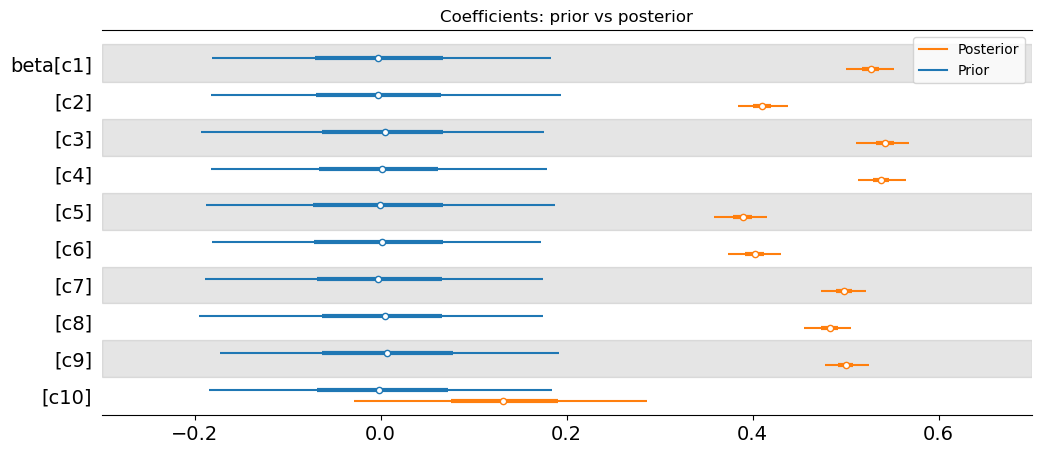

In [31]:
axes, _ = plot_coeff_forest_prior_posterior(
    idata = idata_unpooled, 
    idata_prior = prior_unpooled,
)

The violin plots provide a second view of the same story.

For channels with clear signal (typically c1–c9), posteriors cluster near their true generating values.

For c10 (TOF Brand Paid Social Always-on), the posterior remains much wider because the data simply isn’t informative enough to isolate the effect.


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Posterior distribution of channel coefficients (truth overlaid)'}, xlabel='beta', ylabel='channel'>)

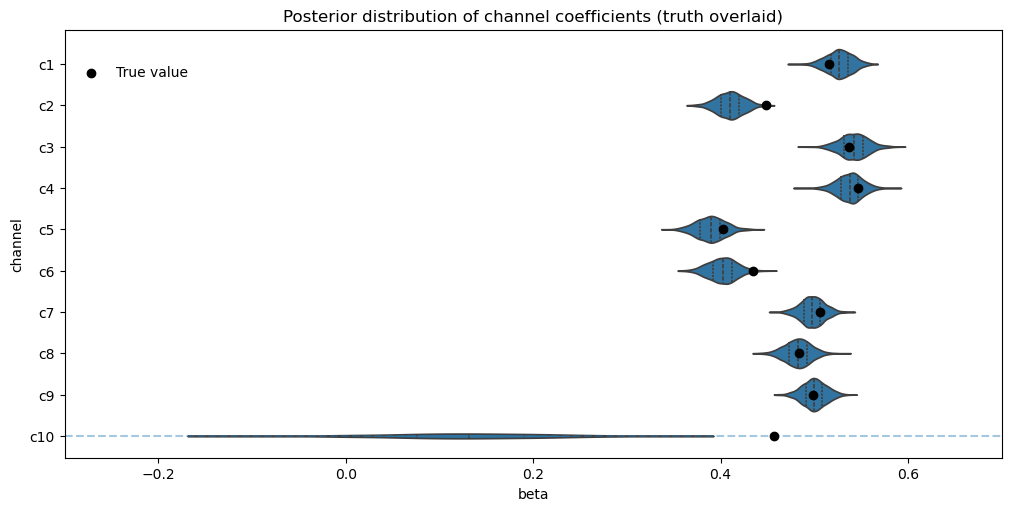

In [32]:
plot_channel_beta_posterior_vs_truth(idata_unpooled, truth)

This motivates hierarchical modeling: we want to stabilize estimates for weakly identified channels (like c10) **without** distorting channels that the data already identifies well.

## Step 2 — Introducing hierarchy (centered parameterization)

Now we introduce a more realistic assumption:

> channel effects are different, but they come from a shared population.

This is the Bayesian version of saying:

**“channels are not identical, but they are comparable.”**

Instead of estimating c10 completely independently, we estimate it as part of a group distribution (partial pooling).

### Why this matters in MMM

In MMM, some channels are strongly identified and others are weakly identified. Hierarchical modeling helps prevent weak channels from producing extreme estimates simply because the model is overfitting noise.

For small channels like c10, this often improves the **location** of the posterior, even if uncertainty remains wide.


In [33]:
# Centered hierarchical log-linear regression using the Prior class.
#
# Model (log scale):
# -- log(y_t) = alpha + sum_j beta_j * log(c_{j,t}) + eps_t
# -- eps_t ~ Normal(0, sigma)
#
# Centered hierarchy on betas:
# -- beta_j ~ Normal(mu_beta, sigma_beta)

with pm.Model(coords=coords) as centered_pp_model:

    Xd = pm.Data("X", X, dims=("date", "channel"))

    # Priors via Prior class
    alpha= Prior("Normal", mu=0.5, sigma=0.5).create_variable("alpha")

    # --- CHANGES COME IN HERE ---

    beta = Prior(
        "Normal",  
        mu=Prior("Normal", mu=0.0, sigma=0.1), 
        sigma=Prior("HalfNormal", sigma=0.1), 
        dims="channel",
    ).create_variable("beta")

    # --- CHANGES DONE, BACK TO NORMAL CODE ---

    sigma = Prior("HalfNormal", sigma=0.5).create_variable("sigma")

    mu = pm.Deterministic(
        "mu",
        alpha + pm.math.dot(Xd, beta),
        dims="date",
    )

    pm.Normal(
        "y_obs",
        mu=mu,
        sigma=sigma,
        observed=y_obs,
        dims="date",
    )

    # Sales-scale posterior predictive (noise-free and noisy)
    y_mean = pm.Deterministic("y_mean", pm.math.exp(mu), dims="date")
    y_rep = pm.Deterministic(
        "y_rep",
        pm.math.exp(mu + pm.Normal.dist(0.0, sigma)),
        dims="date",
    )

    idata_centered_pp = pm.sample(
        draws=500,
        tune=500,
        chains=4,
        target_accept=0.9,
        random_seed=42,
        return_inferencedata=True,
    )

    idata_centered_pp = pm.sample_posterior_predictive(
        idata_centered_pp,
        var_names=["y_obs", "y_mean", "y_rep"],
        random_seed=42,
        extend_inferencedata=True,
    )

    prior_centered_pp = pm.sample_prior_predictive(samples=1000, random_seed=42)

# Apply marketing-friendly labels for plotting
apply_channel_labels_to_idata(idata_centered_pp, CHANNEL_NAME)
apply_channel_labels_to_idata(prior_centered_pp, CHANNEL_NAME)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_mu, beta_sigma, beta, sigma]


Output()

/Users/jakepiekarski/mmm_training/.pixi/envs/default/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/jakepiekarski/mmm_training/.pixi/envs/default/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/jakepiekarski/mmm_training/.pixi/envs/default/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: overflow encountered in power
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/jakepiekarski/mmm_training/.pixi/envs/default/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: overflow encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/jakepiekarski/mmm_training/.pixi/envs/default/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered i

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
Sampling: [y_obs]


Output()

Sampling: [alpha, beta, beta_mu, beta_sigma, sigma, y_obs]


### Takeaway (centered hierarchy)

With partial pooling, the posterior for **c10** typically shifts toward a more plausible region, because the estimate is informed by the shared distribution of channel effects.

However, **uncertainty can remain large** (wide HDI) if c10’s data is genuinely uninformative. Hierarchy improves stability and plausibility, but it cannot invent signal.

Also, centered hierarchical models can sample poorly when signal is weak — which is why we often switch to a non-centered parameterization in practice.


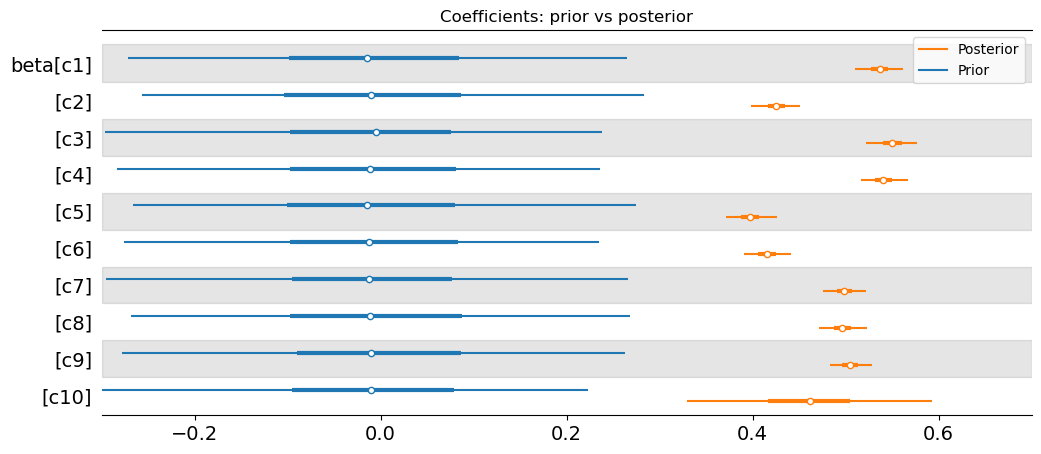

In [34]:
axes, _ = plot_coeff_forest_prior_posterior(
    idata = idata_centered_pp, 
    idata_prior = prior_centered_pp,
)

The violin plot usually makes the practical value of partial pooling obvious:

- c10’s posterior centers closer to a plausible value
- the distribution is still wide if the data doesn’t strongly identify the channel

This is often exactly what you want for always-on brand activity: a conservative estimate that avoids extreme swings unless the data truly supports them.


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Posterior distribution of channel coefficients (truth overlaid)'}, xlabel='beta', ylabel='channel'>)

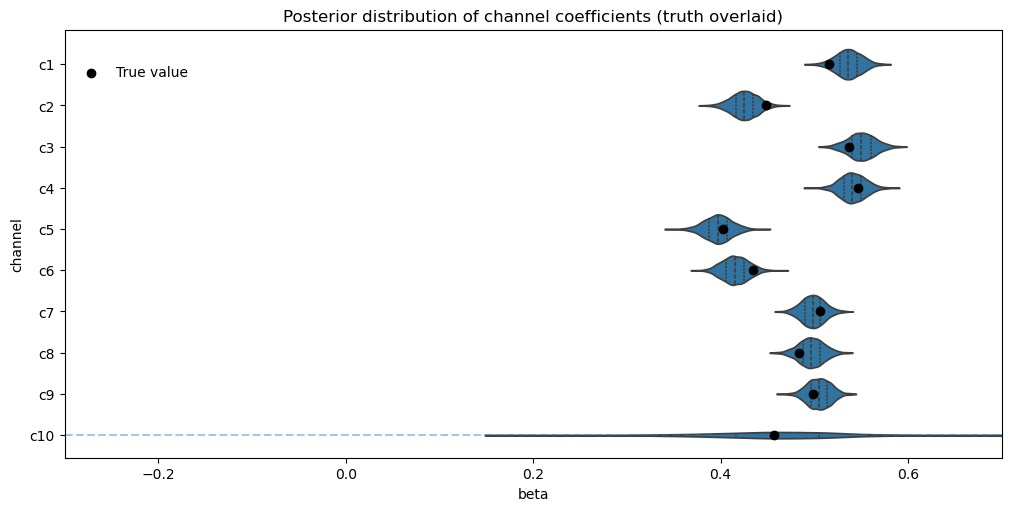

In [35]:
plot_channel_beta_posterior_vs_truth(idata_centered_pp, truth)

## Step 3 — Non-centered hierarchy (same assumptions, better sampling)

Next we fit the same hierarchical model, but using a **non-centered parameterization**.

This is a technical detail — but an important one when some channels have weak signal.

### What changes?

The marketing assumptions are the same (partial pooling). What changes is the parameterization, which often improves sampling when hierarchical models form a difficult posterior geometry (the classic “funnel” problem).

In MMM terms: non-centering often leads to more stable inference when some channels are poorly identified.


### Centered vs non-centered parameterizations

Centered and non-centered hierarchical models represent the same statistical assumptions but differ in how parameters are expressed and sampled. A **centered parameterization** is often preferable when groups are well informed by the data and the group-level variance is large, as it allows coefficients to be learned directly from observations. A **non-centered parameterization** is typically more effective when groups are weakly identified, have few observations, or when the group-level variance is small, as it reduces posterior correlations and improves sampling efficiency.

For this dataset, where most channels are well identified but **one channel (`c10`) is weakly informed**, a **non-centered parameterization is generally preferable**. It tends to produce more stable sampling and clearer diagnostics for the weak channel, while yielding similar posterior means to the centered model. Any remaining uncertainty for `c10` reflects a genuine lack of information in the data rather than a limitation of the modeling approach.


In [36]:
# Non-centered hierarchical log-linear regression using the Prior class.
#
# Model (log scale):
# -- log(y_t) = alpha + sum_j beta_j * log(c_{j,t}) + eps_t
# -- eps_t ~ Normal(0, sigma)
#
# Non-centered hierarchy on betas:
# -- z_j ~ Normal(0, 1)
# -- beta_j = mu_beta + sigma_beta * z_j

with pm.Model(coords=coords) as non_centered_pp_model:

    Xd = pm.Data("X", X, dims=("date", "channel"))

    # Priors via Prior class
    alpha = Prior("HalfNormal", sigma=0.5).create_variable("alpha")

    # --- CHANGES COME IN HERE ---

    beta = Prior(
        "Normal", 
        mu=Prior("Normal", mu=0.0, sigma=0.1),
        sigma=Prior("HalfNormal", sigma=0.1), 
        dims="channel",
        centered=False,
    ).create_variable("beta")

    # --- CHANGES DONE, BACK TO NORMAL CODE ---

    sigma = Prior("HalfNormal", sigma=0.5).create_variable("sigma")

    mu = pm.Deterministic(
        "mu",
        alpha + pm.math.dot(Xd, beta),
        dims="date",
    )

    pm.Normal(
        "y_obs",
        mu=mu,
        sigma=sigma,
        observed=y_obs,
        dims="date",
    )

    # Sales-scale posterior predictive (noise-free and noisy)
    y_mean = pm.Deterministic("y_mean", pm.math.exp(mu), dims="date")
    y_rep = pm.Deterministic(
        "y_rep",
        pm.math.exp(mu + pm.Normal.dist(0.0, sigma)),
        dims="date",
    )

    idata_non_centered_pp = pm.sample(
        draws=500,
        tune=500,
        chains=4,
        target_accept=0.95,
        random_seed=42,
        return_inferencedata=True,
    )

    idata_non_centered_pp = pm.sample_posterior_predictive(
        idata_non_centered_pp,
        var_names=["y_obs", "y_mean", "y_rep"],
        random_seed=42,
        extend_inferencedata=True,
    )

    prior_non_centered_pp = pm.sample_prior_predictive(samples=1000, random_seed=42)

# Apply marketing-friendly labels for plotting
apply_channel_labels_to_idata(idata_non_centered_pp, CHANNEL_NAME)
apply_channel_labels_to_idata(prior_non_centered_pp, CHANNEL_NAME)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_offset, beta_mu, beta_sigma, sigma]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


Output()

Sampling: [alpha, beta_mu, beta_offset, beta_sigma, sigma, y_obs]


### Takeaway (non-centered hierarchy)

Non-centering typically doesn’t change the business assumptions — it changes how reliably we can estimate the model.

If you see similar posterior means but better sampling behavior, that’s a win: you’re getting the same inference with less risk of convergence issues.


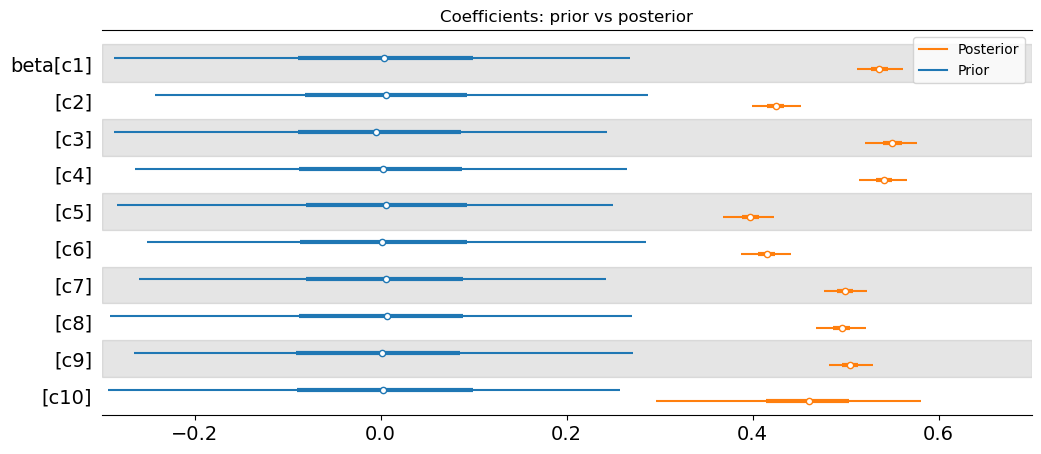

In [37]:
axes, _ = plot_coeff_forest_prior_posterior(
    idata = idata_non_centered_pp, 
    idata_prior = prior_non_centered_pp,
)

The violin plots confirm that the centered and non-centered models imply the same story for channel effects, including c10.

Practical rule of thumb for Bayesian MMM work: if you’re using hierarchical priors, **non-centering is often the safer default**.


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Posterior distribution of channel coefficients (truth overlaid)'}, xlabel='beta', ylabel='channel'>)

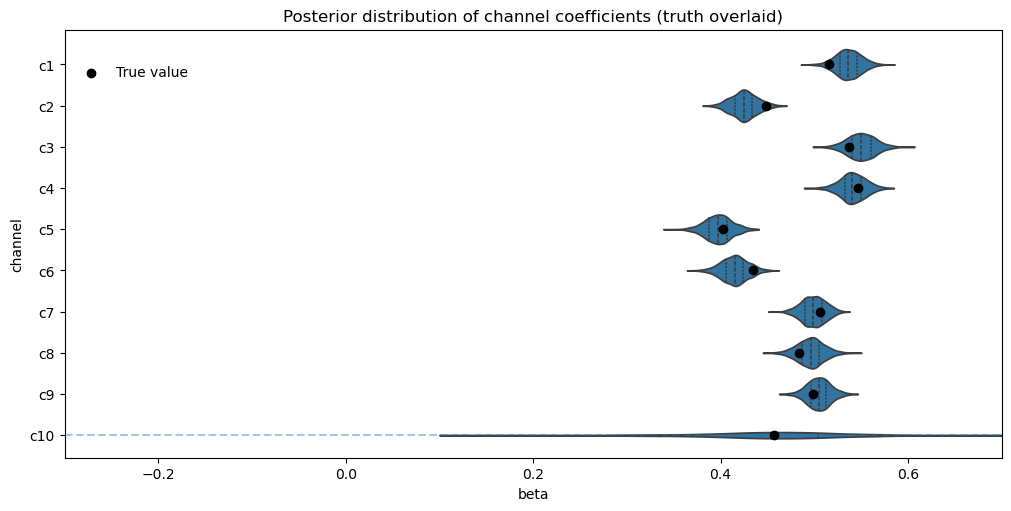

In [38]:
plot_channel_beta_posterior_vs_truth(idata_non_centered_pp, truth)

## Step 4 — Tuning pooling strength (a practical MMM control knob)

So far, we’ve let the model learn how much pooling to apply.

But in marketing measurement, we sometimes want more explicit control.

For example:
- if we believe channels are fairly comparable (common in DTC), we may want stronger pooling
- if we believe channels are structurally different, we may want weaker pooling

To demonstrate this, we introduce a **multiplier on the non-centered offset** for c10. Conceptually, this behaves like a “pooling strength knob”:

- multiplier < 1 → stronger pooling (more shrinkage toward the mean)
- multiplier > 1 → weaker pooling (less shrinkage)

This can be useful when you want to encode a belief like:

> “small channels shouldn’t take extreme values unless there is overwhelming evidence.”


In [39]:
# Non-centered hierarchical log-linear regression with EXTRA pooling for c10
#
# Non-centered hierarchy:
#   z_j ~ Normal(0, 1)
#   beta_j = mu_beta + sigma_beta * s_j * z_j
# 
# We'll set s_c10 < 1 to make c10 more influenced by the global mean.

with pm.Model(coords=coords) as tuned_non_centered_pp_model:

    Xd = pm.Data("X", X, dims=("date", "channel"))

    # Priors via Prior class
    alpha = Prior("HalfNormal", sigma=0.5).create_variable("alpha")

    # --- CHANGES COME IN HERE ---

    # Global hierarchy - unchanged, just separated out for clarity
    mu_beta = Prior("Normal", mu=0.0, sigma=0.1).create_variable("mu_beta")
    sigma_beta = Prior("HalfNormal", sigma=0.1).create_variable("sigma_beta")

    # Standardized deviations (non-centered)
    z = Prior("Normal", mu=0.0, sigma=1.0, dims="channel").create_variable("z")

    # Channel-specific shrinkage multipliers (fixed constants):
    # s_j = 1 for all, but make c10 smaller -> stronger pooling
    channels = coords["channel"]
    s = np.ones(len(channels), dtype=float)
    s[channels.index("c10")] = 0.05  # <-- tune this (smaller = more pooling)

    s_mult = pm.Data("s_mult", s, dims="channel")

    # Apply heterogeneous pooling strength
    beta = pm.Deterministic("beta", mu_beta + sigma_beta * s_mult * z, dims="channel")

    # --- CHANGES DONE, BACK TO NORMAL CODE ---

    sigma = Prior("HalfNormal", sigma=0.5).create_variable("sigma")

    mu = pm.Deterministic(
        "mu",
        alpha + pm.math.dot(Xd, beta),
        dims="date",
    )

    pm.Normal(
        "y_obs",
        mu=mu,
        sigma=sigma,
        observed=y_obs,
        dims="date",
    )

    # Sales-scale posterior predictive (noise-free and noisy)
    y_mean = pm.Deterministic("y_mean", pm.math.exp(mu), dims="date")
    y_rep = pm.Deterministic(
        "y_rep",
        pm.math.exp(mu + pm.Normal.dist(0.0, sigma)),
        dims="date",
    )

    idata_tuned_non_centered_pp = pm.sample(
        draws=500,
        tune=500,
        chains=4,
        target_accept=0.95,
        random_seed=42,
        return_inferencedata=True,
    )

    idata_tuned_non_centered_pp = pm.sample_posterior_predictive(
        idata_tuned_non_centered_pp,
        var_names=["y_obs", "y_mean", "y_rep"],
        random_seed=42,
        extend_inferencedata=True,
    )

    prior_tuned_non_centered_pp = pm.sample_prior_predictive(samples=1000, random_seed=42)

# Apply marketing-friendly labels for plotting
apply_channel_labels_to_idata(idata_tuned_non_centered_pp, CHANNEL_NAME)
apply_channel_labels_to_idata(prior_tuned_non_centered_pp, CHANNEL_NAME)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, mu_beta, sigma_beta, z, sigma]


Output()

/Users/jakepiekarski/mmm_training/.pixi/envs/default/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: overflow encountered in power
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/jakepiekarski/mmm_training/.pixi/envs/default/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: overflow encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/jakepiekarski/mmm_training/.pixi/envs/default/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/jakepiekarski/mmm_training/.pixi/envs/default/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: overflow encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


Output()

Sampling: [alpha, mu_beta, sigma, sigma_beta, y_obs, z]


### Takeaway (tuned pooling)

This tuning approach highlights a key practical truth in Bayesian MMM:

> uncertainty is not only a data problem — it’s also an assumptions problem.

With stronger pooling, c10 becomes more stable and the HDI narrows. You are explicitly choosing to be more conservative about how far a weakly identified channel can drift from the “typical” channel effect.

The tradeoff is important:
- **strong pooling** → more stability, less variance  
- **weak pooling** → more channel individuality, more uncertainty


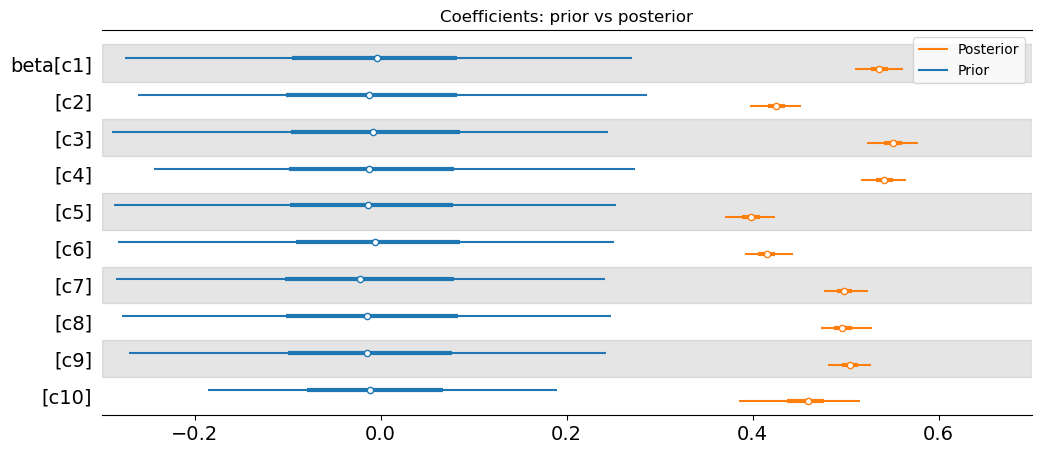

In [40]:
axes, _ = plot_coeff_forest_prior_posterior(
    idata = idata_tuned_non_centered_pp, 
    idata_prior = prior_tuned_non_centered_pp,
)

If the true value sits comfortably inside the posterior while the posterior mass becomes more concentrated, that’s the practical benefit of hierarchical regularization for small always-on channels: **more usable estimates without pretending the data is stronger than it is.**

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Posterior distribution of channel coefficients (truth overlaid)'}, xlabel='beta', ylabel='channel'>)

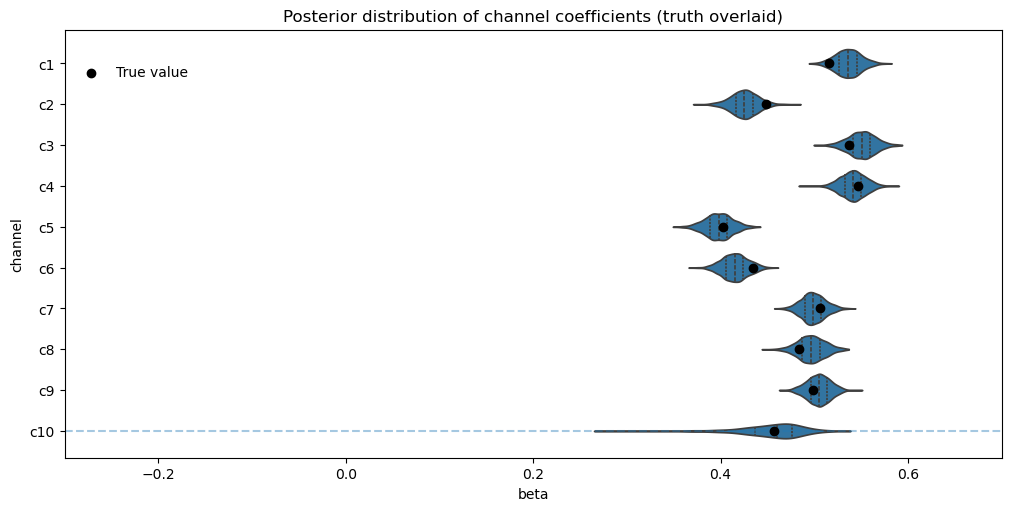

In [41]:
plot_channel_beta_posterior_vs_truth(idata_tuned_non_centered_pp, truth)

## Executive view — how c10 changes across assumptions

Below, we compare the posterior for **Paid Social (TOF Brand Always-on)** across the four models on a single chart and a simple summary table.

This is the “so what” for marketing decision-making: same data, different assumptions, different stability.


In [ ]:
# Executive comparison: c10 across models
import numpy as np

# Ensure friendly labels are applied
for _idata in [idata_unpooled, idata_centered_pp, idata_non_centered_pp, idata_tuned_non_centered_pp]:
    apply_channel_labels_to_idata(_idata, CHANNEL_NAME)

# Forest plot comparing c10 across models
az.plot_forest(
    [idata_unpooled, idata_centered_pp, idata_non_centered_pp, idata_tuned_non_centered_pp],
    var_names=["beta"],
    coords={"channel": [WEAK_CHANNEL_LABEL]},
    combined=True,
    hdi_prob=0.94,
    model_names=["Unpooled", "Centered hierarchy", "Non-centered hierarchy", "Non-centered + tuned pooling"],
    figsize=(10, 3.5),
)
plt.title(f"Same data, different assumptions: {WEAK_CHANNEL_LABEL} effect (94% HDI)")
plt.xlabel("Effect size (beta)")
plt.show()


def summarize_channel(idata, channel_label, rope=0.0):
    beta = idata.posterior["beta"].sel(channel=channel_label)
    samples = beta.stack(sample=("chain", "draw")).values
    mean = float(np.mean(samples))
    hdi_low, hdi_high = az.hdi(samples, hdi_prob=0.94).tolist()
    p_pos = float(np.mean(samples > rope))
    return {"mean_beta": mean, "hdi_94_low": hdi_low, "hdi_94_high": hdi_high, "P(beta>0)": p_pos}


def compare_models_table(idatas, model_names, channel_label):
    rows = []
    for idata, name in zip(idatas, model_names):
        s = summarize_channel(idata, channel_label)
        s["model"] = name
        rows.append(s)
    return pd.DataFrame(rows).set_index("model")


compare_models_table(
    idatas=[idata_unpooled, idata_centered_pp, idata_non_centered_pp, idata_tuned_non_centered_pp],
    model_names=["Unpooled", "Centered hierarchy", "Non-centered hierarchy", "Non-centered + tuned pooling"],
    channel_label=WEAK_CHANNEL_LABEL,
)


# Final thoughts: what this means for real MMM work

This notebook demonstrates a common MMM scenario:

- A small channel exists in the mix  
- It’s always on  
- It has weak variation  
- It probably contributes something  
- But the data alone cannot clearly isolate its impact  

An unpooled model will often produce a noisy, unstable estimate.

A hierarchical model introduces a reasonable marketing assumption:

> channels share some common structure, so weak channels can borrow strength.

The result is usually a posterior that is:
- more plausible  
- more stable  
- still honestly uncertain when the signal is weak  

### Practical recommendations (PyMC / Bayesian MMM)
- Hierarchical priors are a strong default when you have weak channels.  
- Non-centered parameterization is often the safer implementation.  
- Pooling strength can be treated as a modeling choice (a conservativeness dial), not just something to “let the sampler decide”.

In other words:

> good MMM measurement is not only about fitting the data — it’s about encoding realistic assumptions about marketing systems.
